#### Ace0 model comparison

In [206]:
%load_ext autoreload
%autoreload 2

import os
import traceback
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, AdditiveKernel, MaternKernel, SpectralMixtureKernel, \
        PiecewisePolynomialKernel, PolynomialKernel, RQKernel, RFFKernel
from gpytorch.priors import GammaPrior, HorseshoePrior

import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"../../")

import itertools
import collections
from adjustText import adjust_text
import arviz as az
import xarray as xr

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP
from modules.prior import UniformPrior, BetaPrior
from modules.metrics import mean_sum_composition_errors, scotts_pi
from modules.stats_utils import compute_nlpd, compute_log_likelihood
from modules.cdaf import plot_cdaf
import scipy.stats as st

# set plotting theme
from matplotlib.ticker import MultipleLocator
from cycler import cycler
plt.style.use('default')
# color_cycle = ['#348ABD', '#E24A33', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
# default_color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
rcparam_update = {
    "axes.titlesize": 'large',
    "axes.labelsize": 12,
    "figure.labelsize": "large", 
    "figure.titlesize": "large",
    'legend.fontsize': 10,
    'legend.title_fontsize': 'large',
    'xtick.labelsize': 12,
    'ytick.labelsize': 10,
    # 'axes.prop_cycle': cycler('color', color_cycle),
    'axes.facecolor': '#fdfdff',
    "font.family": "FreeSans",
    'figure.figsize': [6.4, 4.8], # default
}
plt.rcParams.update(rcparam_update)
save_image_path = "/mnt/c/Users/huyca/OneDrive/Thesis_tex/Figures/ace0/model"
dpi = 600
savefig = True
kernel_n = "3"

from matplotlib import ticker
n_ticks = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Setup data

In [207]:
test_id = {
    0: "SA-HMOGP",
    1: "A-HMOGP",
    2: "IA-GGP",
    3: "HMOGP",
}

# palette = {
#     "SA-HMOGP": "#360332",
#     "A-HMOGP": '#c989c4',
#     "IA-GGP": "#4A5492",
#     "HMOGP": "#6F499D",
# }

palette = {
    "SA-HMOGP": "#360332",
    "A-HMOGP": '#BFADD5',
    "IA-GGP": "#3566AF",
    "HMOGP": "#E1B2B2",
}

In [208]:
def is_numeric(x):
        return isinstance(x,(np.int32, np.float32, np.int64, np.float64, int, float))

def adjust_kernel_id(kernel_id, n_kernels):
        new_kernel_id = n_kernels + ((kernel_id+1)/10)
        return new_kernel_id

def geometric_mean(x):
        gm = np.exp(np.log(x).mean())
        return np.round(gm, 4)

def compute_geometric_mean(df, cols, new_col_name):
        df[cols] = df[cols].apply(lambda x: x + np.abs(np.min(x)) + 1 if np.min(x) < 0 else x)
        df[new_col_name] = df[cols].apply(lambda x: geometric_mean(x), axis=1)
        return df

def get_csv_path(n_kernels, version=1):
        csv_path = f"./model_comparisons_v{version}/kernels_len_{n_kernels}/"
        return csv_path

In [209]:
class Metrics:
    
    def __init__(self, path, n_kernels):
        self.path = path
        self.n_kernels = n_kernels
        
        _csv_files = os.listdir(self.path)
        _csv_files = [csv for csv in _csv_files if csv.endswith(".csv")]
        self.variable_list = [csv.replace("_df.csv", "") for csv in _csv_files]
        
        test_id = {
            0: "SA-HMOGP",
            1: "A-HMOGP",
            2: "IA-GGP",
            3: "HMOGP",
            4: "SA-HMOGP",
            5: "HMOGP",
        }
        
        for variable, csv in zip(self.variable_list, _csv_files):
            variable_name = variable
            df = pd.read_csv(os.path.join(path, csv), index_col=0)
            df.test_id = df.test_id.apply(lambda x: test_id[x] if is_numeric(x) else x)
            df.kcid = df.kcid.apply(lambda x: adjust_kernel_id(x, self.n_kernels))
            if "msce" in variable_name:
                cols = ["y1", "y2"]
                df["mean"] = df[cols].apply(lambda x: x.mean(), axis=1)
            elif "agreement" in variable_name:
                cols = ["y0", "y3", "y4"]
                df["mean"] = df[cols].apply(lambda x: x.mean(), axis=1)
            setattr(self, variable, df)

            if "waic" in variable_name:
                cols = ['elpd_waic_y0', 'elpd_waic_y1', 'elpd_waic_y2','elpd_waic_y3', 'elpd_waic_y4']
                df_gm = df.copy()
                df_gm = compute_geometric_mean(df_gm, cols, "adj_elpd_waic")
                setattr(self, variable_name + "_gm", df_gm)
                self.variable_list.append(variable_name + "_gm")
            elif "nlpd" in variable_name:
                cols = ['y0', 'y1', 'y2', 'y3', 'y4']
                df_gm = df.copy()
                df_gm = compute_geometric_mean(df_gm, cols, "adj_nlpd")
                setattr(self, variable_name + "_gm", df_gm)
                self.variable_list.append(variable_name + "_gm")
                
    def compare_baseline(self, metric:str, kernel_id):
        assert metric in self.variable_list
        df = getattr(self, metric)
        cond = (df.test_id.isin(["SA-HMOGP", "HMOGP"]))
        if metric == "agreement":
            cond &= df.weight == "quadratic"
        if isinstance(kernel_id, float):
            cond &= df.kcid == kernel_id
        elif isinstance(kernel_id, list):
            cond &= df.kcid.isin(kernel_id)
        else:
            raise ValueError("invalid kernel id.")
        return df[cond]

In [210]:
# metrics2 = Metrics(get_csv_path(2), 2)
metrics3 = Metrics(get_csv_path(3), 3)
# metrics6 = Metrics(get_csv_path(6), 6)
# metrics9 = Metrics(get_csv_path(9), 9)
# metrics18 = Metrics(get_csv_path(18), 18)

agreement_cols = ["y0", "y3", "y4", "mean"]
agreement = pd.concat([
    metrics3.agreement,
    # metrics6.agreement,
])
agreement = agreement.reset_index(drop=True)

msce_cols = ["y1", "y2"]
msce = pd.concat([
    metrics3.msce,
    # metrics6.msce,
])
msce = msce.reset_index(drop=True)

waic = pd.concat([
    metrics3.waic,
    # metrics6.waic,
])
waic = waic.reset_index(drop=True)

waic_cols = ['elpd_waic_y0', 'elpd_waic_y1', 'elpd_waic_y2','elpd_waic_y3', 'elpd_waic_y4']
waic_gm = waic.copy()
waic_gm = compute_geometric_mean(waic_gm, waic_cols, "adj_elpd_waic")

nlpd = pd.concat([
    metrics3.nlpd,
    # metrics6.nlpd,
])
nlpd = nlpd.reset_index(drop=True)

nlpd_cols = ['y0', 'y1', 'y2', 'y3', 'y4']
cols = ['y0', 'y1', 'y2', 'y3', 'y4']
nlpd_gm = nlpd.copy()
nlpd_gm = compute_geometric_mean(nlpd_gm, nlpd_cols, "adj_nlpd")

kcid3 = metrics3.nlpd.kcid.unique()
# kcid6 = metrics6.nlpd.kcid.unique()

# kcid = [kcid3, kcid6]
kcid = [kcid3]

In [211]:
2 % 2

0

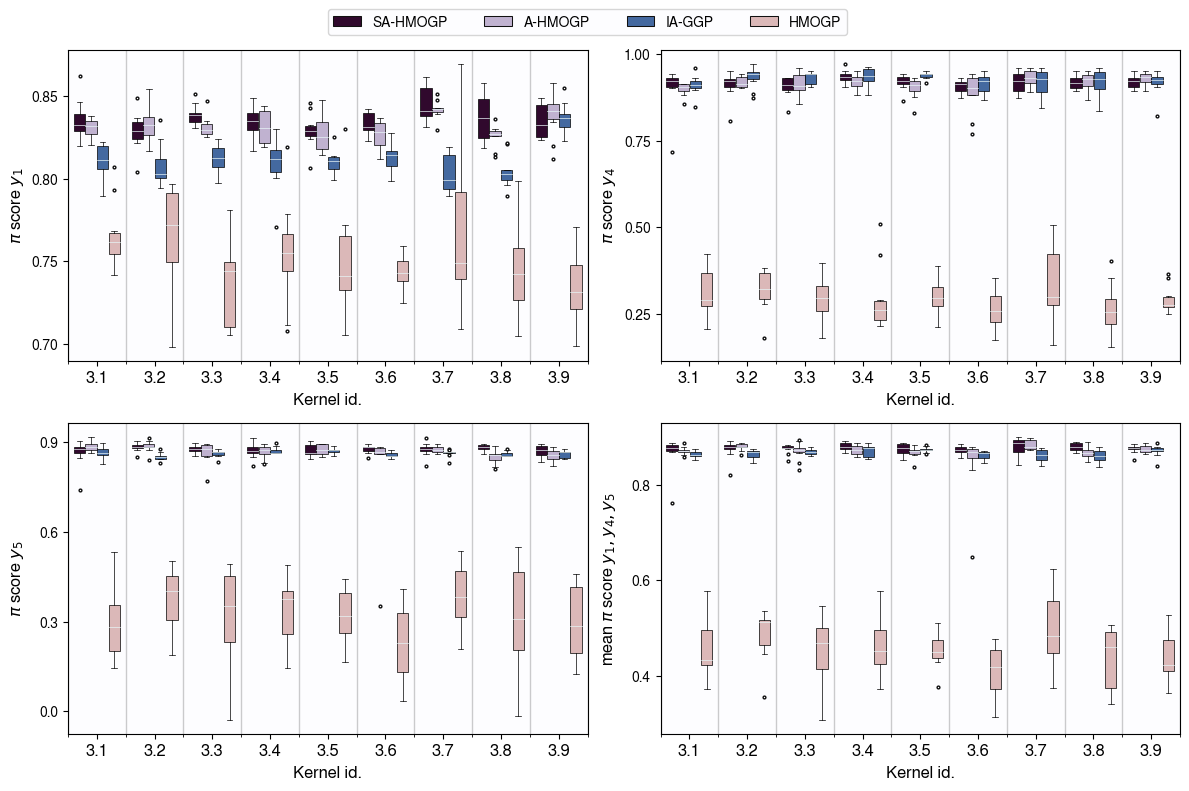

In [212]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
idx = [1,4,5, None]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=False, sharex=False)

for n, d, y, in zip(list(range(4)), idx, agreement_cols):
    i = n // 2 
    j = n % 2
    
    if (i==1) and (j==1):
        sns.boxplot(data=agreement[(agreement.weight=="quadratic")], x="kcid", y="mean", hue="test_id", ax=ax[i,j], palette=palette, **props)
        ax[i,j].set_ylabel(r"mean $\pi$ score $y_1, y_4, y_5$")
        
    else:
        sns.boxplot(data=agreement[(agreement.weight=="quadratic")], x="kcid", y=y, hue="test_id", ax=ax[i,j], palette=palette, **props)
        ax[i,j].set_ylabel(r"$\pi$ score $y_{}$".format(d))      # added
    
    ax[i,j].get_legend().remove()
    
    ax[i,j].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i,j].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i,j].set_xlabel("Kernel id.")
    
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i,j].yaxis.set_major_locator(yticks)   # added
    


ax[0,0].legend(bbox_to_anchor=(.5, 1.05, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
fig.align_ylabels(ax)
fig.tight_layout()
if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_agreement.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

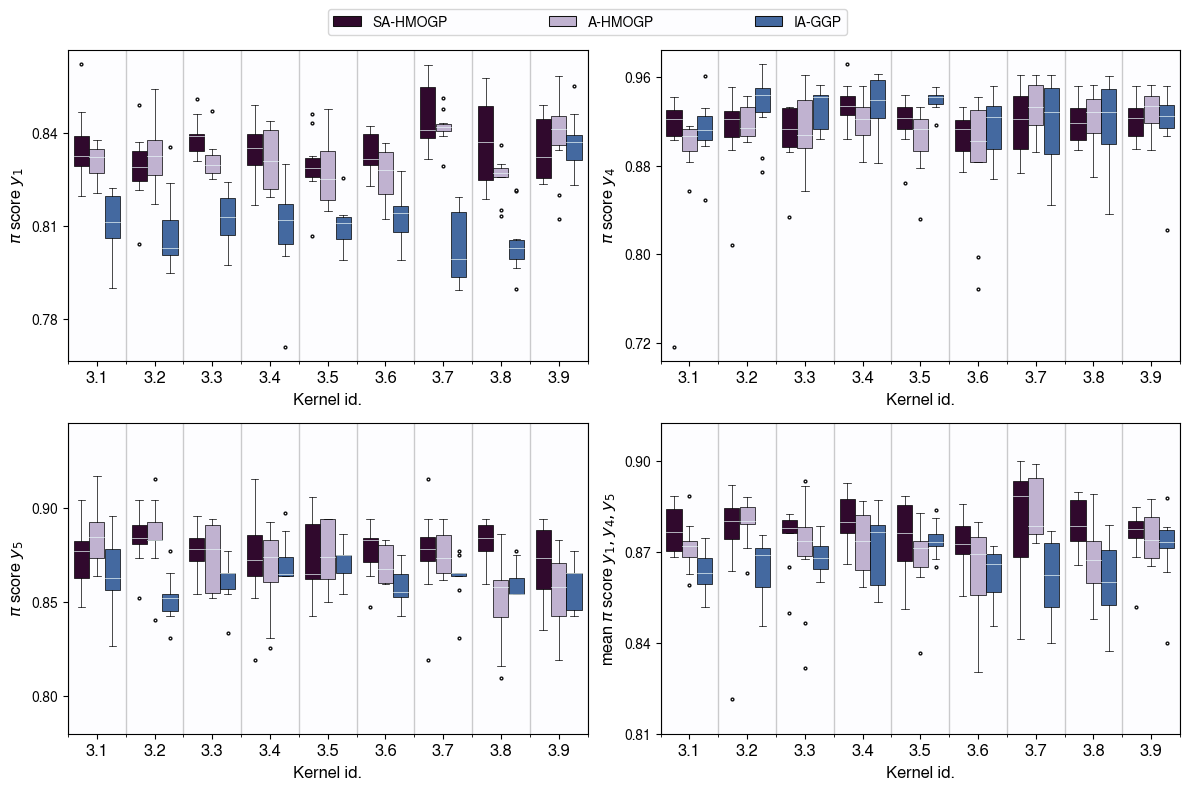

In [213]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
idx = [1,4,5, None]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=False, sharex=False)

for n, d, y, in zip(list(range(4)), idx, agreement_cols):
    i = n // 2 
    j = n % 2
    
    if (i==1) and (j==1):
        sns.boxplot(data=agreement[(agreement.weight=="quadratic") & (agreement.test_id != "HMOGP")], x="kcid", y="mean", hue="test_id", ax=ax[i,j], palette=palette, **props)
        ax[i,j].set_ylabel(r"mean $\pi$ score $y_1, y_4, y_5$")
        
    else:
        sns.boxplot(data=agreement[(agreement.weight=="quadratic")  & (agreement.test_id != "HMOGP")], x="kcid", y=y, hue="test_id", ax=ax[i,j], palette=palette, **props)
        ax[i,j].set_ylabel(r"$\pi$ score $y_{}$".format(d))      # added
    
    ax[i,j].get_legend().remove()
    
    ax[i,j].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i,j].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i,j].set_xlabel("Kernel id.")
    
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i,j].yaxis.set_major_locator(yticks)   # added


ax[0,0].legend(bbox_to_anchor=(.5, 1.05, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added

ax[1,0].set_ylim(.78,ax[1,0].get_ylim()[1])
ax[1,1].set_ylim(.81,ax[1,1].get_ylim()[1])

for axis in ax.flatten():
    axis.yaxis.set_tick_params(labelleft=True)

fig.align_ylabels(ax)
fig.tight_layout()
if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_agreement_additive.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

HD: calculate coefficient of variation

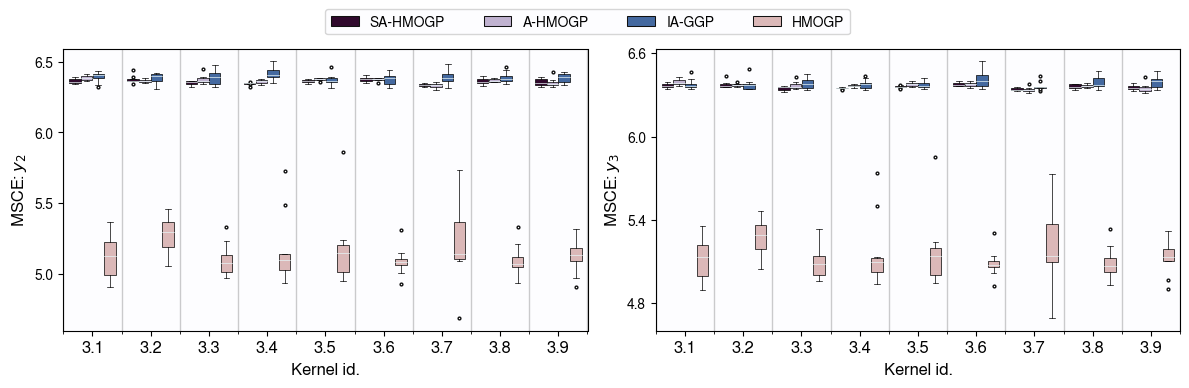

In [214]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
msce_cols = ["y1", "y2"]
fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=False, sharex=False)
i = 0
for idx, y in enumerate(msce_cols, start=2):
    sns.boxplot(data=msce, x="kcid", y=y, hue="test_id", ax=ax[i], palette=palette, **props)
    ax[i].get_legend().remove()
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i].set_xlabel("Kernel id.")
    ax[i].set_ylabel("")                    # added
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i].yaxis.set_major_locator(yticks)   # added
    ax[i].set_ylabel(r"MSCE: $y_{}$".format(idx))      # added
    i += 1

ax[0].legend(bbox_to_anchor=(.5, 1.05, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
    
    
fig.align_ylabels(ax)
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_msce.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

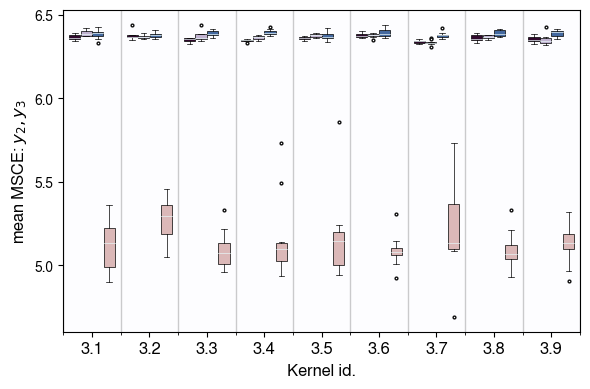

In [215]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(ncols=1, figsize=(6,4), sharey=True, sharex=False)
for i, kcid_n in enumerate(kcid):
    sns.boxplot(data=msce[msce.kcid.isin(kcid_n)], x="kcid", y="mean", hue="test_id", ax=ax, palette=palette, **props)
    ax.get_legend().remove()
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax.set_xlabel("Kernel id.")
    ax.set_ylabel("")                    # added
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax.yaxis.set_major_locator(yticks)   # added

# ax.legend(bbox_to_anchor=(.5, 1.05, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
ax.set_ylabel(r"mean MSCE: $y_2, y_3$")
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_msce_gm.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

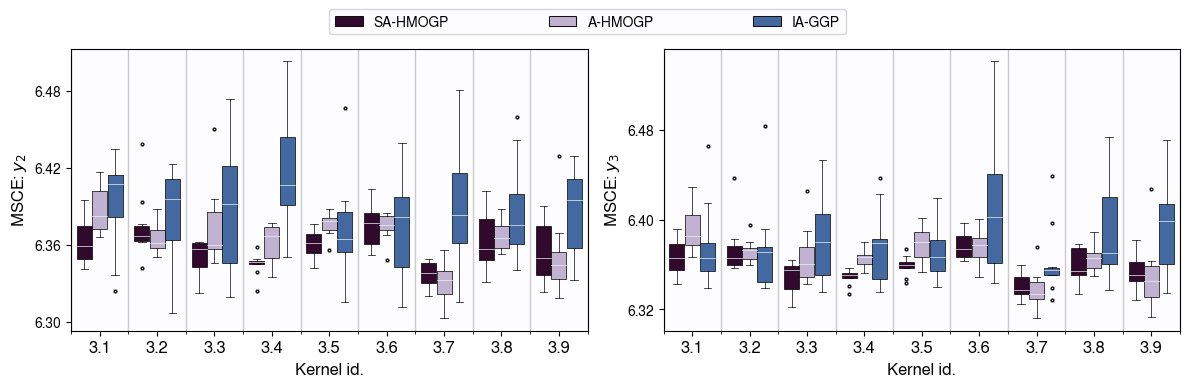

In [216]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
msce_cols = ["y1", "y2"]
fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=False, sharex=False)
i = 0
for idx, y in enumerate(msce_cols, start=2):
    sns.boxplot(data=msce[(msce.test_id != "HMOGP")], x="kcid", y=y, hue="test_id", ax=ax[i], palette=palette, **props)
    ax[i].get_legend().remove()
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i].set_xlabel("Kernel id.")
    ax[i].set_ylabel("")                    # added
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i].yaxis.set_major_locator(yticks)   # added
    ax[i].set_ylabel(r"MSCE: $y_{}$".format(idx))      # added
    i += 1

ax[0].legend(bbox_to_anchor=(.5, 1.05, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
    
    
fig.align_ylabels(ax)
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_msce_additive.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

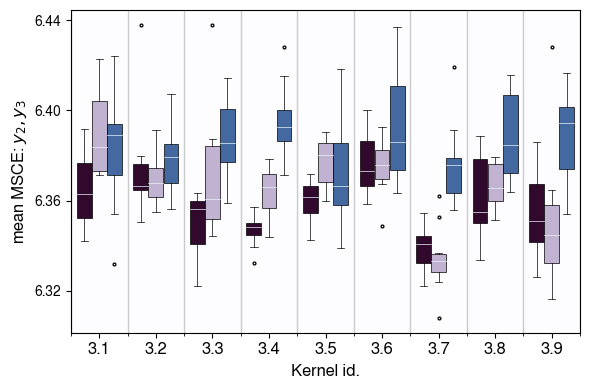

In [217]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(ncols=1, figsize=(6,4), sharey=True, sharex=False)
for i, kcid_n in enumerate(kcid):
    sns.boxplot(data=msce[(msce.test_id != "HMOGP")], x="kcid", y="mean", hue="test_id", ax=ax, palette=palette, **props)
    ax.get_legend().remove()
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax.set_xlabel("Kernel id.")
    ax.set_ylabel("")                    # added
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax.yaxis.set_major_locator(yticks)   # added

# ax.legend(bbox_to_anchor=(.5, 1.05, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
ax.set_ylabel(r"mean MSCE: $y_2, y_3$")
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_msce_gm_additive.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

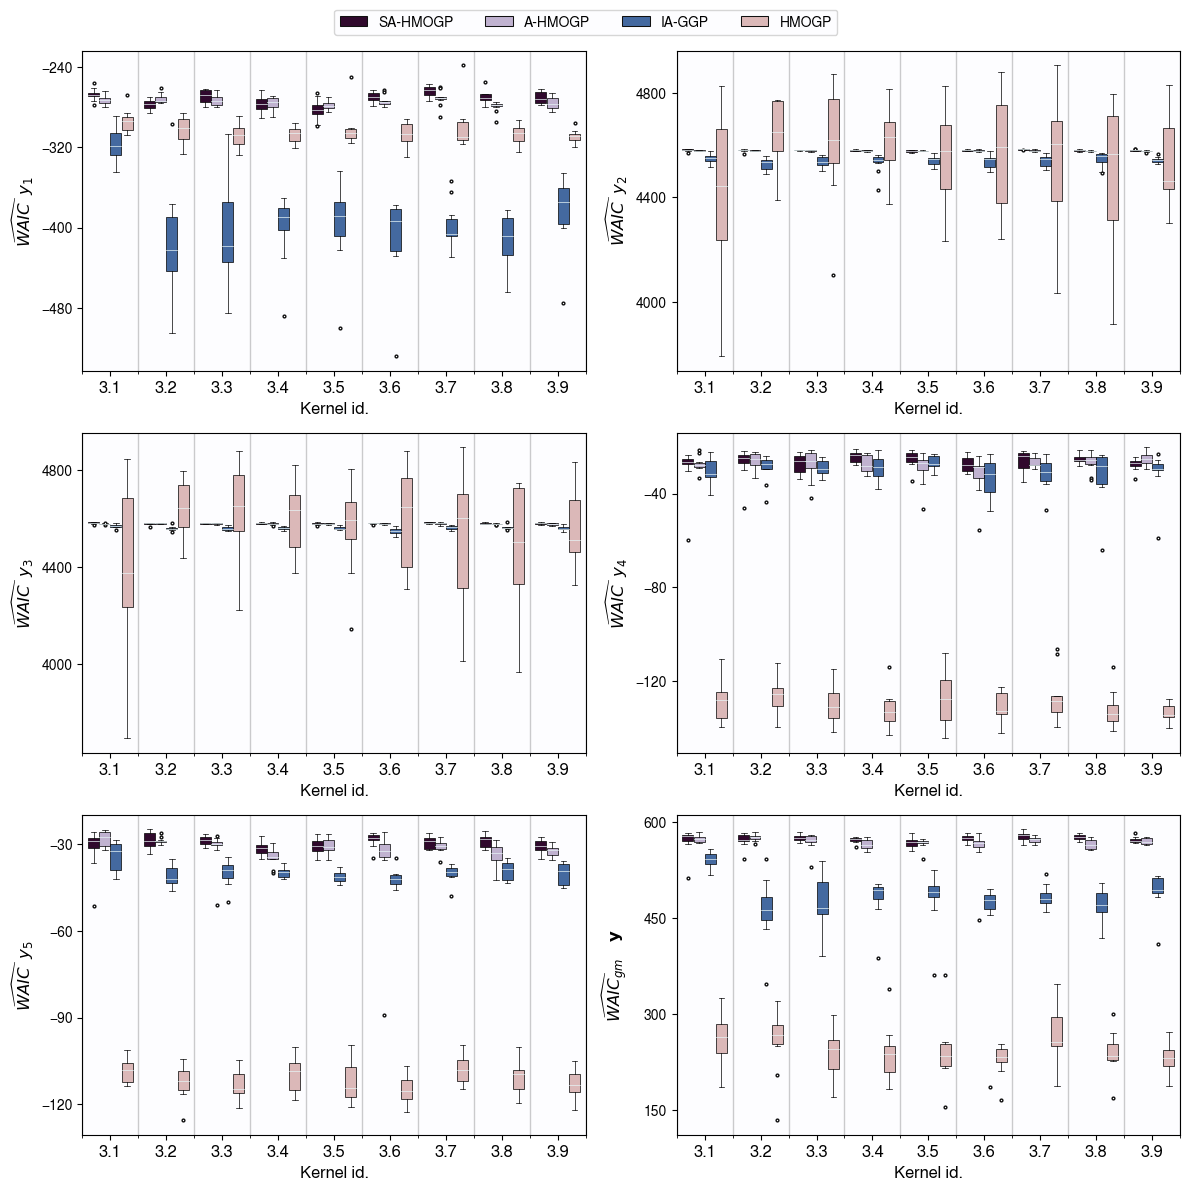

In [218]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
waic_cols = ['elpd_waic_y0', 'elpd_waic_y1', 'elpd_waic_y2','elpd_waic_y3', 'elpd_waic_y4', None]


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12), sharey=False, sharex=False)

n = 0
for d, y in enumerate(waic_cols, start=1):
    i = n // 2
    j = n % 2
    
    if (i==2) and (j==1):
        sns.boxplot(data=waic_gm, x="kcid", y="adj_elpd_waic", hue="test_id", ax=ax[i,j], palette=palette, **props)
        ax[i,j].set_ylabel(r"${{\widehat{{{}}}}}_{{gm}}$    $\mathbf{{y}}$".format("WAIC"))
    else:
        sns.boxplot(data=waic, x="kcid", y=y, hue="test_id", ax=ax[i,j], palette=palette, **props)
        ax[i,j].set_ylabel(r"${{\widehat{{{}}}}}$  $y_{}$".format("WAIC", d))      # added
    ax[i,j].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i,j].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i,j].set_xlabel("Kernel id.")
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i,j].yaxis.set_major_locator(yticks)   # added
        
        
    ax[i,j].get_legend().remove()
    n += 1

ax[0,0].legend(bbox_to_anchor=(.5, 1.05, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added

fig.align_ylabels(ax)
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_waic.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

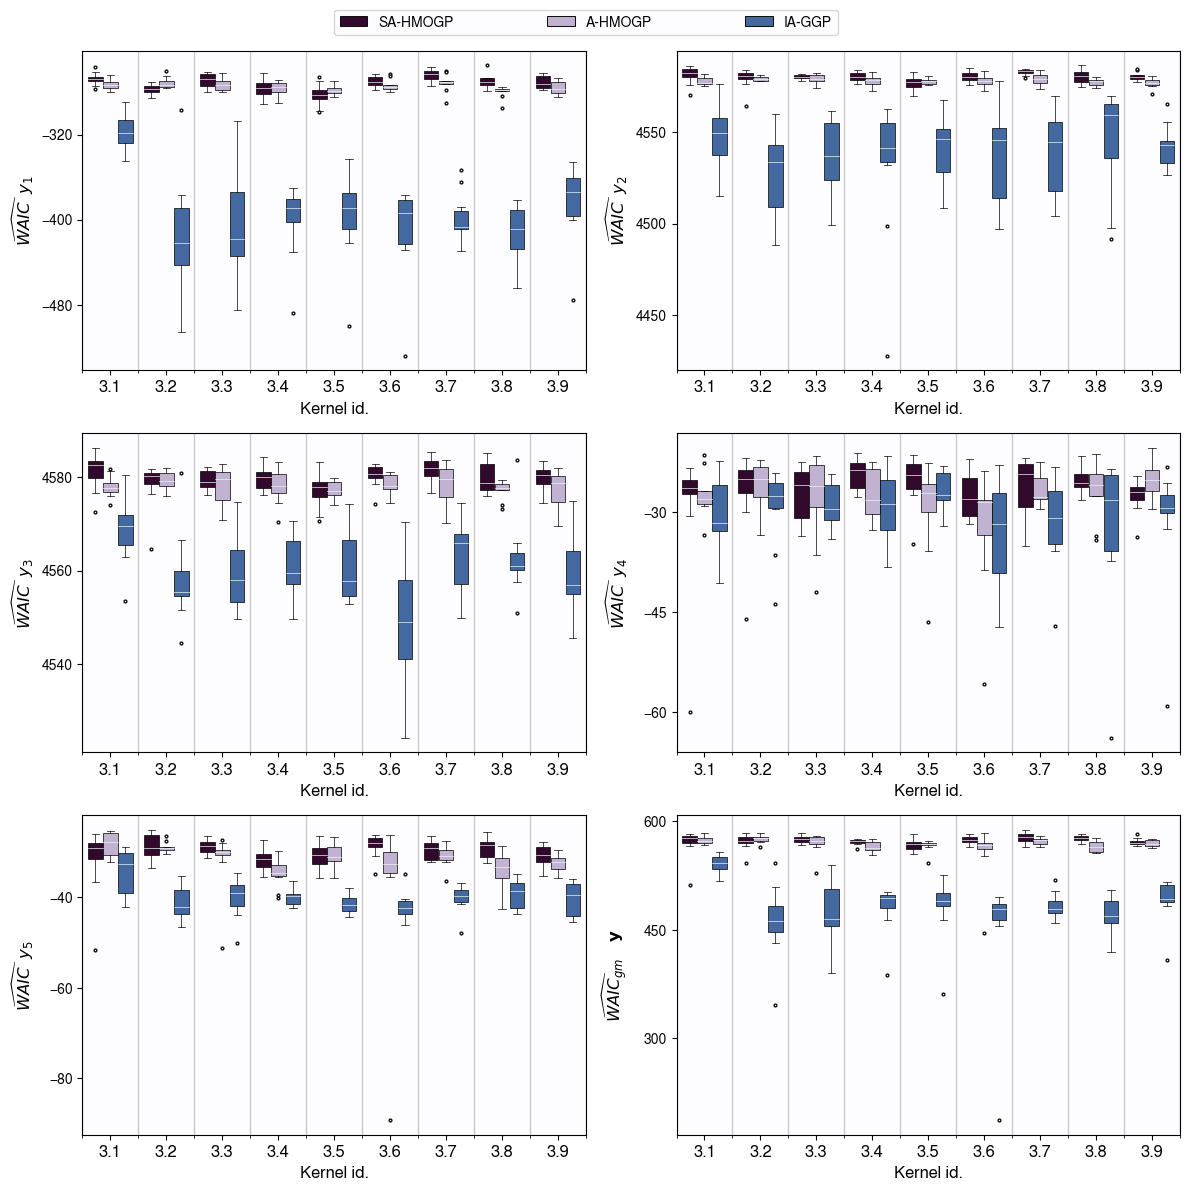

In [219]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
waic_cols = ['elpd_waic_y0', 'elpd_waic_y1', 'elpd_waic_y2','elpd_waic_y3', 'elpd_waic_y4', None]


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12), sharey=False, sharex=False)

n = 0
for d, y in enumerate(waic_cols, start=1):
    i = n // 2
    j = n % 2
    
    if (i==2) and (j==1):
        sns.boxplot(data=waic_gm[waic_gm.test_id != "HMOGP"], x="kcid", y="adj_elpd_waic", hue="test_id", ax=ax[i,j], palette=palette, **props)
        ax[i,j].set_ylabel(r"${{\widehat{{{}}}}}_{{gm}}$    $\mathbf{{y}}$".format("WAIC"))
    else:
        sns.boxplot(data=waic[waic.test_id != "HMOGP"], x="kcid", y=y, hue="test_id", ax=ax[i,j], palette=palette, **props)
        ax[i,j].set_ylabel(r"${{\widehat{{{}}}}}$  $y_{}$".format("WAIC", d))      # added
    ax[i,j].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i,j].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i,j].set_xlabel("Kernel id.")
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i,j].yaxis.set_major_locator(yticks)   # added
        
        
    ax[i,j].get_legend().remove()
    n += 1

ax[0,0].legend(bbox_to_anchor=(.5, 1.05, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added

fig.align_ylabels(ax)
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_waic_additive.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

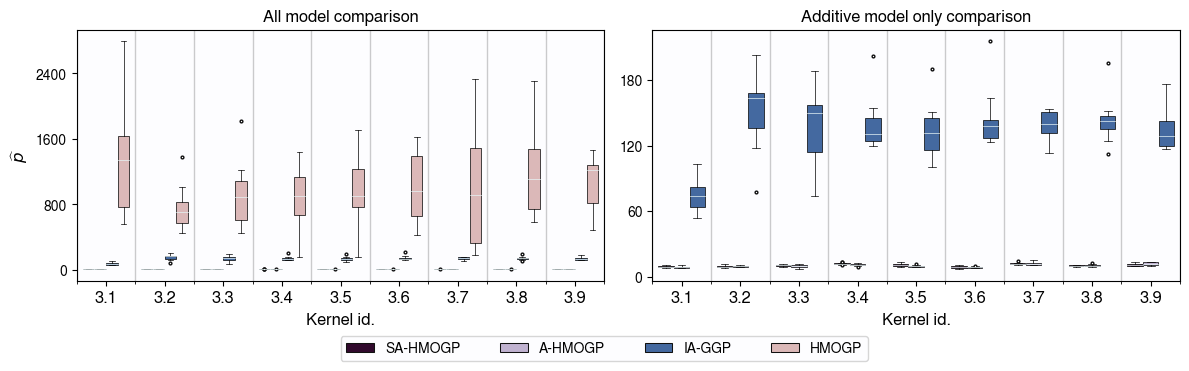

In [239]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=False, sharex=False)
sub_models = ["", "HMOGP"]
for i, m in enumerate(sub_models):
    sns.boxplot(data=waic[waic.test_id != m], x="kcid", y="p_waic", hue="test_id", ax=ax[i], palette=palette, **props)
    ax[i].get_legend().remove()
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i].set_xlabel("Kernel id.")
    ax[i].set_ylabel("")                    # added
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i].yaxis.set_major_locator(yticks)   # added

ax[0].legend(bbox_to_anchor=(.5, -.32, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
ax[0].set_ylabel(r"${{\widehat{{{}}}}}$".format("p"))

ax[0].set_title("All model comparison")
ax[1].set_title("Additive model only comparison")
fig.align_ylabels(ax)
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_effective_n_param.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

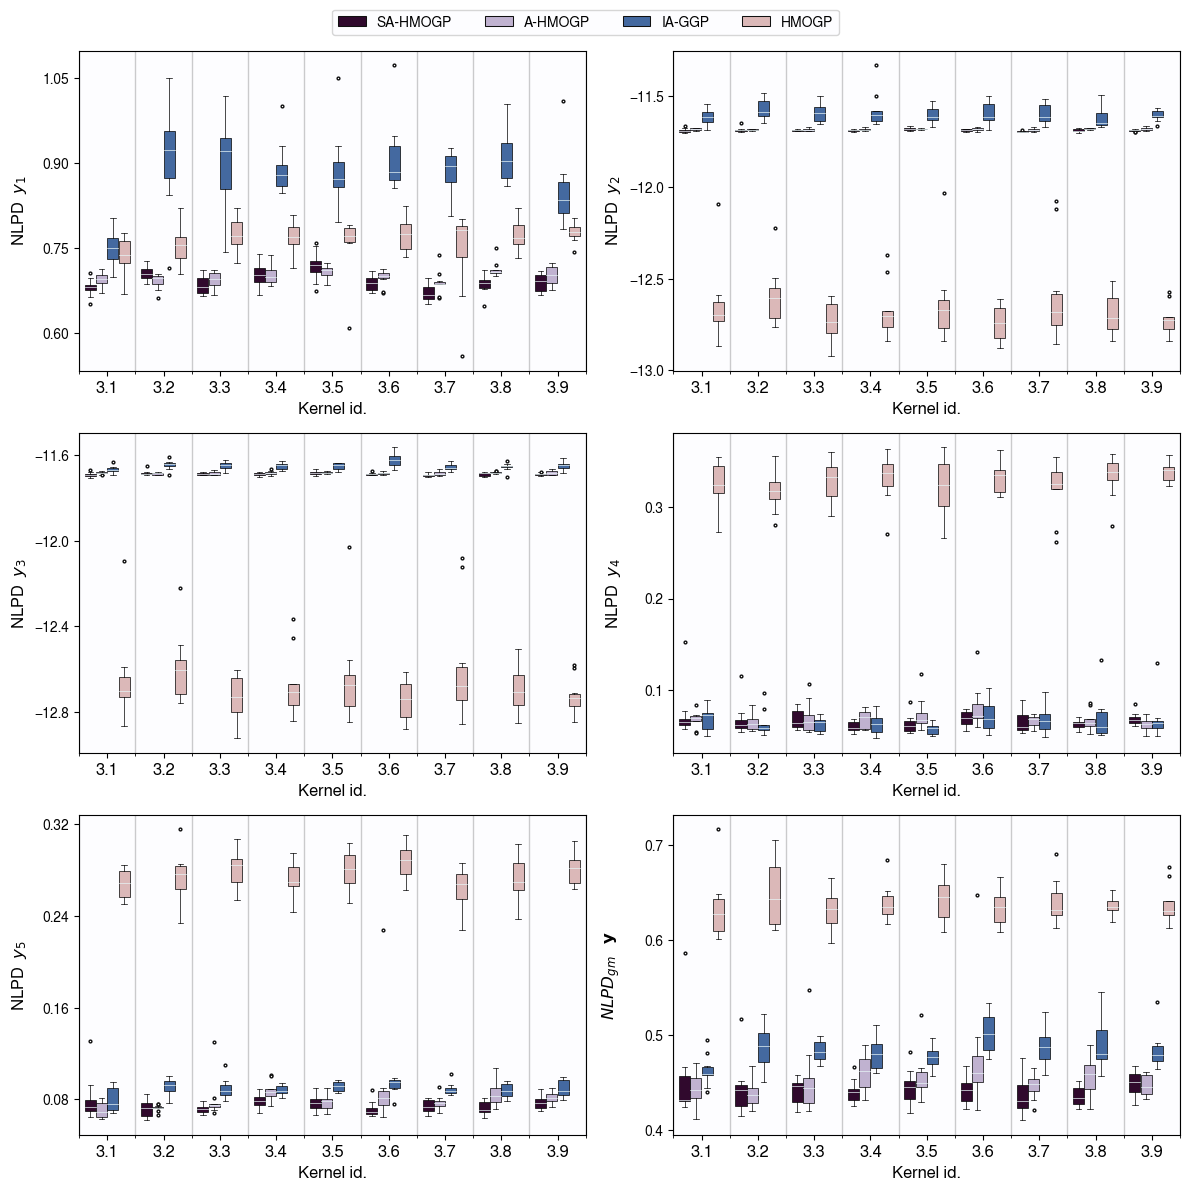

In [224]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
nlpd_cols = ['y0', 'y1', 'y2', 'y3', 'y4', None]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12), sharey=False, sharex=False)
n = 0
for d, y in enumerate(nlpd_cols, start=1):
    i = n // 2
    j = n % 2
    if (i==2) and (j==1):
        sns.boxplot(data=nlpd_gm, x="kcid", y="adj_nlpd", hue="test_id", ax=ax[i,j], palette=palette, **props)
        ax[i,j].set_ylabel(r"${{{}}}_{{{}}}$   $\mathbf{{y}}$".format("NLPD", "gm", i))
    else:
        sns.boxplot(data=nlpd, x="kcid", y=y, hue="test_id", ax=ax[i,j], palette=palette, **props)
        ax[i,j].set_ylabel(r"NLPD  $y_{}$".format(d))      # added
    ax[i,j].get_legend().remove()
    
    ax[i,j].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i,j].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i,j].set_xlabel("Kernel id.")
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i,j].yaxis.set_major_locator(yticks)   # added
    n += 1

ax[0,0].legend(bbox_to_anchor=(.5, 1.05, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added

fig.align_ylabels(ax)
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_nlpd.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

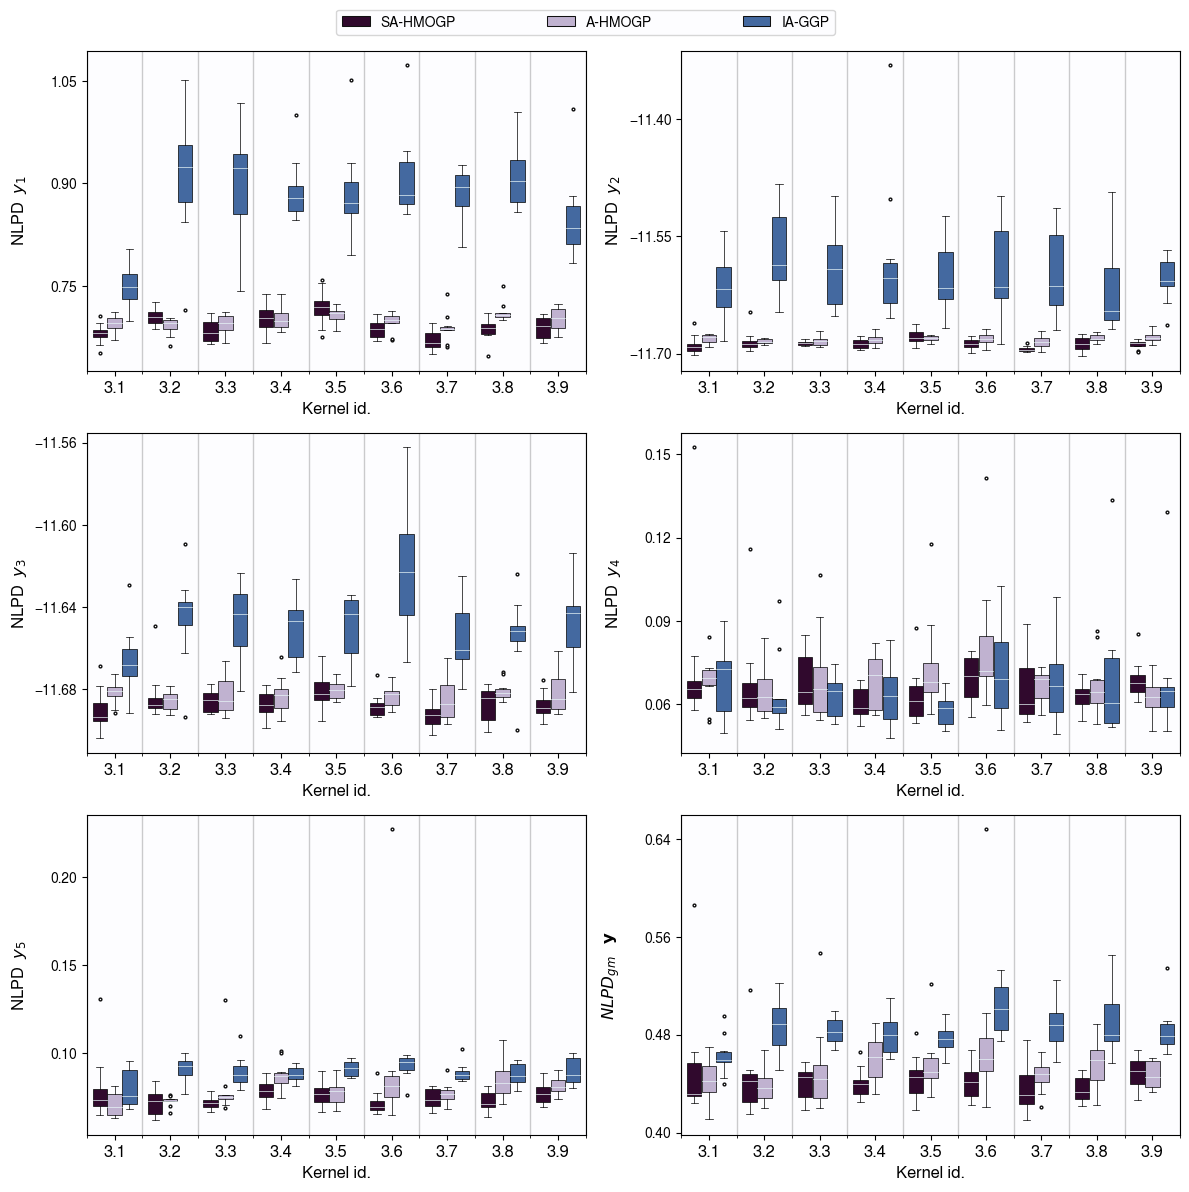

In [225]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
nlpd_cols = ['y0', 'y1', 'y2', 'y3', 'y4', None]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12), sharey=False, sharex=False)
n = 0
for d, y in enumerate(nlpd_cols, start=1):
    i = n // 2
    j = n % 2
    if (i==2) and (j==1):
        sns.boxplot(data=nlpd_gm[nlpd_gm.test_id != "HMOGP"], x="kcid", y="adj_nlpd", hue="test_id", ax=ax[i,j], palette=palette, **props)
        ax[i,j].set_ylabel(r"${{{}}}_{{{}}}$   $\mathbf{{y}}$".format("NLPD", "gm", i))
    else:
        sns.boxplot(data=nlpd[nlpd.test_id != "HMOGP"], x="kcid", y=y, hue="test_id", ax=ax[i,j], palette=palette, **props)
        ax[i,j].set_ylabel(r"NLPD  $y_{}$".format(d))      # added
    ax[i,j].get_legend().remove()
    
    ax[i,j].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i,j].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i,j].set_xlabel("Kernel id.")
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i,j].yaxis.set_major_locator(yticks)   # added
    n += 1

ax[0,0].legend(bbox_to_anchor=(.5, 1.05, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added

# ax[2,0].set_ylim(ax[2,0].get_ylim()[0], .125)
# ax[2,1].set_ylim(ax[2,1].get_ylim()[0], .56)
fig.align_ylabels(ax)
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_nlpd_additive.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [2]:
kernel_structure_df

NameError: name 'kernel_structure_df' is not defined